This notebook will train an Support Vector Classifier (SVC) model to categorize customers by their Customer Lifetime Value. The data will be categroized by their quantiles going by 20 percentiles. The data will be standardized and reduced using Principal Component Analysis (PCA) and fed into an SVC.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

customer_data = pd.read_csv(r"Marketing-Customer-Value.csv")


After viewing the data set, we are dropping the "Effective To Date" , "Response", and "Customer" columns as we won't use them in the customer segmentation. 

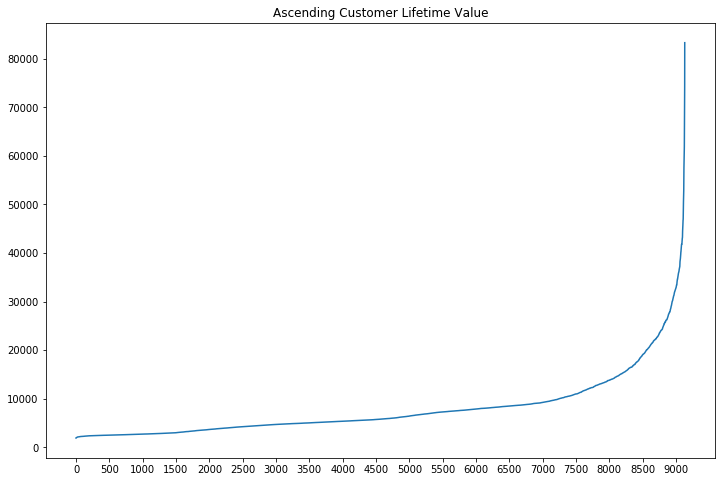

In [2]:
fv=plt.figure(1)
CLV = customer_data['Customer Lifetime Value']
plt.title("Ascending Customer Lifetime Value")
fv.set_size_inches(12,8)
vals = CLV.sort_values().reset_index(drop='true')
plt.xticks(np.arange(0, max(vals.index),step= 500))
plt.plot(vals.index,vals)

plt.show()

We will create stratas of Customer Lifetime values by using their quantiles. We will be praticularly interested in how strata 4 (the 80-100th percetile) is scored in or SVC as marketing campaigns and retention efforts revolve around the top 20th percentile of customer because they provide the most revenue. 

In [3]:
strats = np.where(CLV <= CLV.quantile(.20),0,np.where(CLV <= CLV.quantile(.4),1,np.where(CLV <= CLV.quantile(.6),2,np.where(CLV <= CLV.quantile(.8),3,4))))
customer_data = pd.concat([customer_data, pd.DataFrame(data=strats, columns =['Strata'])], axis=1)
customer_data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Strata
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,0
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,2
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,4
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,3
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,0


Now we will convert the qualatative data using label encoder for columns with two elements and dummy columns for the rest.

In [4]:
from sklearn.preprocessing import LabelEncoder
qual_cols = customer_data.select_dtypes('object')
for Col_name in qual_cols.keys():
    if qual_cols[Col_name].nunique() >2:
        dummy = pd.get_dummies(qual_cols[Col_name])
        customer_data = pd.concat([customer_data.drop(Col_name,axis=1),dummy],axis=1)
    else:
        le = LabelEncoder()
        le.fit(qual_cols[Col_name])
        trans =pd.DataFrame(le.transform(qual_cols[Col_name]))
        trans.columns=[Col_name]
        customer_data = pd.concat([customer_data.drop(Col_name,axis = 1),trans],axis=1)
        
        

In [5]:
customer_data.head()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Strata,AA10041,...,Web,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car,Large,Medsize,Small
0,2763.519279,56274,69,32,5,0,1,384.811147,0,0,...,0,0,0,0,0,0,1,0,1,0
1,6979.535903,0,94,13,42,0,8,1131.464935,2,0,...,0,1,0,0,0,0,0,0,1,0
2,12887.431650,48767,108,18,38,0,2,566.472247,4,0,...,0,0,0,0,0,0,1,0,1,0
3,7645.861827,0,106,18,65,0,7,529.881344,3,0,...,0,0,0,0,1,0,0,0,1,0
4,2813.692575,43836,73,12,44,0,1,138.130879,0,0,...,0,1,0,0,0,0,0,0,1,0


Now, the data will be broken into training and testing sets. A validation set is not needed as we will use GridsearchCV which uses holdout data form the training set for cross-validation during hyperparameter tuning. 

In [6]:
from random import randint
from sklearn.model_selection import train_test_split
X = customer_data.drop(['Customer Lifetime Value','Strata'],axis=1)
X_train,X_test, y_train, y_test = train_test_split(X ,customer_data['Strata'], test_size=0.25, random_state=19482)


Both data sets will be standardized.

In [7]:
col = ['Income','Monthly Premium Auto','Months Since Last Claim','Months Since Policy Inception','Number of Open Complaints','Number of Policies','Total Claim Amount']
def Standardize(x,col):
    y = (x[col]-x[col].mean())/(x[col].std())
    z = pd.concat([x.drop(col,axis= 1),y],axis=1)
    return(z)
    

X_train,X_test = Standardize(X_train,col),Standardize(X_test,col)

Now, we will reduce the dimensionality using Principal Component Analysis (PCA)  on our training set and apply the transformation to our Testing. PCA is needed as feeding 61 components into an SVC invites variation that is noise like from components with small explained variances leading to poor preformance. 

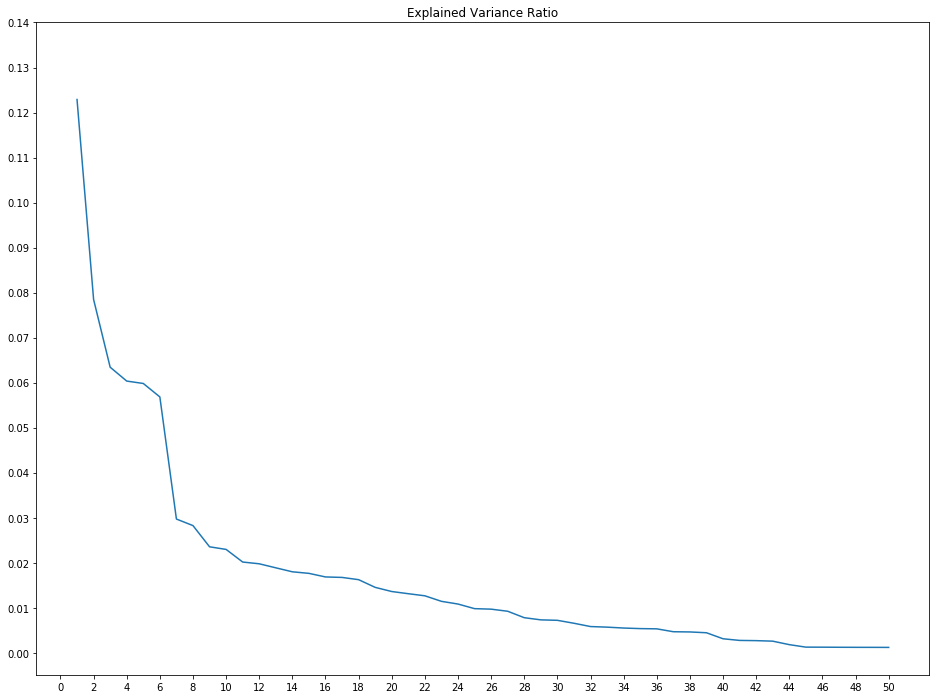

In [8]:
from sklearn.decomposition import PCA
pca=PCA(n_components=61 ,svd_solver='full')
pca.fit(X_train)
evr = pca.explained_variance_ratio_
fevr = plt.figure(3)       
plt.plot(range(1,51),evr[0:50])
plt.title("Explained Variance Ratio")
fevr.set_size_inches(16,12)
plt.xticks(np.arange(0, 52,step=2))
plt.yticks(np.arange(0,.15,step=.01))
plt.show()



In [16]:
sum(evr[0:19])

0.7053745129636406

20 components explain 75% of variance in the data. Typically we shoot for 80-85% explaince variance but remaining components have very small explained variance ratios which could act as noise.

In [10]:
pca = PCA(n_components=20)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Now, we will train our SVC and use GridsearchCV for our hyperparameter tuning. We are using f1_score instead of accuracy as our scoring method but not because of an imbalnce in the amount of our stratas. F1 score is prefered as spending money on a falsely identified top 20% customer/ignoring an actual top 20% customer is wasteful.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 

params = {'kernel': ('rbf','sigmoid','poly'),
         'degree': [2,3,4,5,6],
          'gamma': ('auto','scale'),
          'C' : [.5,1,2,3,5,10]
        }
SVC = SVC(probability = True)
model = GridSearchCV(SVC, params,metrics.make_scorer(metrics.f1_score, average='micro'))
model = model.fit(X_train_pca,y_train)

best_params = model.best_params_

print(best_params)

	



C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


Training data classification report

In [13]:
from sklearn.metrics import classification_report
train_pred =model.predict(X_train_pca) 
print(classification_report(y_train, train_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1401
           1       0.98      0.94      0.96      1363
           2       0.93      0.95      0.94      1364
           3       0.90      0.93      0.92      1360
           4       0.93      0.92      0.92      1362

    accuracy                           0.95      6850
   macro avg       0.95      0.95      0.95      6850
weighted avg       0.95      0.95      0.95      6850



Testing data classificaiton report.

In [15]:
test_pred =model.predict(X_test_pca) 
print(classification_report(y_test, test_pred)) 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       426
           1       0.90      0.83      0.86       464
           2       0.79      0.81      0.80       462
           3       0.75      0.76      0.76       472
           4       0.80      0.81      0.81       460

    accuracy                           0.84      2284
   macro avg       0.84      0.84      0.84      2284
weighted avg       0.84      0.84      0.84      2284



We had an f1_score of 84 over all and specifically an f1 score of 81 for strata 4, the group of most interest. I would say this model works well overall and could be useful in marketing and customer retention efforts by classifying the most valuable cutomers. 